In [1]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [30]:
h, w = 5, 5
size = (h, w)

In [31]:
image1 = np.zeros(size, dtype=np.int8)
image2 = np.zeros(size, dtype=np.int8)

In [35]:
image1[1:4:2, 0:3:2] = 1
image1[2, 1] = 1
for i in range(w):
    image2[i, i] = 1
    image2[w-i-1, i] = 1

image1[1, 0] = 0

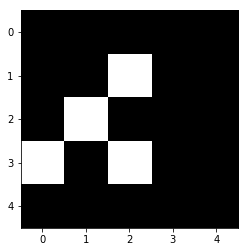

In [36]:
plt.imshow(image1, cmap='gray', vmin=0, vmax=1)

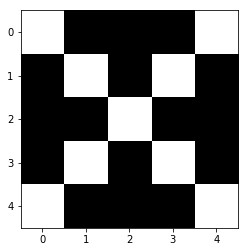

In [37]:
plt.imshow(image2, cmap='gray', vmin=0, vmax=1)

In [72]:
def image2coord(image, w):
    img = np.array(np.where(image==1))
    img[0, :] = w - img[0, :] - 1
    img = img[::-1, :]
    return img

def invariant(img):
    res = []
    for row in img:
        spatial = row - row.mean()
        print(spatial, (spatial.max() - spatial.min()))
        res.append((2 * spatial) / (spatial.max() - spatial.min()))
    return np.array(res, dtype=np.float16)

def centralize(img):
    res = []
    for row in img:
        res.append(row - row.mean())
    return np.array(res, dtype=np.float16)

In [73]:
img1 = image2coord(image1, h)
img2 = image2coord(image2, h)

print(img1)
print(img2)

[[2 1 0 2]
 [3 2 1 1]]
[[0 4 1 3 2 1 3 0 4]
 [4 4 3 3 2 1 1 0 0]]


In [74]:
centroid1 = img1.mean(1)
centroid2 = img2.mean(1)

print(centroid1)
print(centroid2)

[1.25 1.75]
[2. 2.]


In [75]:
central1 = centralize(img1)
central2 = centralize(img2)

print(central1)
print(central2)

[[ 0.75 -0.25 -1.25  0.75]
 [ 1.25  0.25 -0.75 -0.75]]
[[-2.  2. -1.  1.  0. -1.  1. -2.  2.]
 [ 2.  2.  1.  1.  0. -1. -1. -2. -2.]]


In [76]:
invariant1 = invariant(img1)
invariant2 = invariant(img2)

print(invariant1)
print(invariant2)

[ 0.75 -0.25 -1.25  0.75] 2.0
[ 1.25  0.25 -0.75 -0.75] 2.0
[-2.  2. -1.  1.  0. -1.  1. -2.  2.] 4.0
[ 2.  2.  1.  1.  0. -1. -1. -2. -2.] 4.0
[[ 0.75 -0.25 -1.25  0.75]
 [ 1.25  0.25 -0.75 -0.75]]
[[-1.   1.  -0.5  0.5  0.  -0.5  0.5 -1.   1. ]
 [ 1.   1.   0.5  0.5  0.  -0.5 -0.5 -1.  -1. ]]


In [25]:
unique1, indices1 = np.unique(invariant1, axis=1, return_index=True)
unique2, indices2 = np.unique(invariant2, axis=1, return_index=True)

print(unique1)
print(unique2)
print()
print(img1[:, indices1])
print(img2[:, indices2])

[[-1 -1  1  1]
 [-1  1 -1  1]]
[[-1 -1  0  1  1]
 [-1  1  0 -1  1]]

[[0 0 2 2]
 [1 3 1 3]]
[[0 0 1 4 4]
 [0 4 3 0 4]]


In [29]:
z1 = np.transpose(invariant1)
z2 = np.transpose(invariant2)

ab = defaultdict(list)

for index, check in enumerate(z1):
    ab[index].extend([i for i, col in enumerate(z2) if (col == check).all()])
ab

defaultdict(list, {0: [0], 1: [1], 2: [7], 3: [8]})

In [27]:
img2

array([[0, 4, 1, 3, 2, 1, 3, 0, 4],
       [4, 4, 3, 3, 2, 1, 1, 0, 0]], dtype=int64)

In [451]:
def optimize(X, Y):
    def transform(x):
        return ((X * x[0]) + x[1])
    
    def constraint(x):
        return Y - transform(x)

    def objective(x):
        return sum([v**2 for v in x])**0.5

    def callback(x):
        solutions.append(x)

    solutions = []
    max_guess = 100
    n_params = 2

    print(X, Y)

    # initial guesses
    # x0=np.random.randint(max_guess, size=total_number_of_options)
    x0 = np.full(n_params, max_guess)

    # solutions
    solutions = [x0]

    # show initial objective
    print('Initial SSE Objective: {:.4f} at x = {}, transform = {:.4f}, error = {:.4f}'.format(
            objective(x0), x0, transform(x0), constraint(x0)
        )
    )

    # the bounds
    b = (-max_guess, max_guess)
    bnds = tuple(b for _ in range(n_params))
    
    # define constriants
    cons = ([
        {'type': 'eq', 'fun': constraint},
    ])

    solution = minimize(objective, x0, method='SLSQP', bounds=bnds,
                        constraints=cons, callback=callback)
    x = solution.x

    # show final objective
    print('Final SSE Objective: {:.4f} at x = {}, transform = {:.4f}, error = {:.4f}'.format(
            objective(x), x, transform(x), constraint(x)
        ), end='\n\n'
    )


In [452]:
X1, X2 = centroid1
Y1, Y2 = centroid2

In [453]:
optimize(X1, Y1)

1.0 2.0
Initial SSE Objective: 141.4214 at x = [100 100], transform = 200.0000, error = -198.0000
Final SSE Objective: 1.4142 at x = [1. 1.], transform = 2.0000, error = -0.0000



In [454]:
optimize(X2, Y2)

2.0 2.0
Initial SSE Objective: 141.4214 at x = [100 100], transform = 300.0000, error = -298.0000
Final SSE Objective: 0.8944 at x = [0.8 0.4], transform = 2.0000, error = 0.0000

